## Dry Natural Gas Production (U.S. Total) — EIA
Monthly series (NG.N9070US2.M) fetched from EIA, 
converted to daily/business-day to align with Henry Hub price for modeling.

In [7]:
# === CONFIG ===
EIA_API_KEY = "8TyQKfFimNgTg1rHsnQMcXp1cqJkmgtwepZQ6FPB" 
START_DATE  = "2010-01-01"

PROD_RAW_CSV = "us_dry_gas_production_monthly.csv"
PROD_DAILY_CSV = "us_dry_gas_production_daily_ffill.csv"
PROD_BIZ_CSV = "us_dry_gas_production_biz.csv"

import requests
import pandas as pd
import matplotlib.pyplot as plt

### Fetch U.S. Dry Natural Gas Production (Monthly)

We use the EIA v2 series endpoint because it's the simplest for this series:
- Series ID: NG.N9070US2.M (monthly)
- Endpoint: https://api.eia.gov/series/?api_key=...&series_id=NG.N9070US2.M

In [3]:
def fetch_dry_production(api_key, start=START_DATE, page_len=5000):
    base_url = "https://api.eia.gov/v2/natural-gas/prod/sum/data"
    rows_all, offset = [], 0
    while True:
        payload = {
            "frequency": "monthly",
            "data": ["value"],
            "facets": {"series": ["N9070US2"]},  # U.S. Dry NG Production
            "start": start[:7],                  # 'YYYY-MM'
            "sort": [{"column": "period", "direction": "asc"}],
            "offset": offset,
            "length": page_len
        }
        r = requests.post(base_url, params={"api_key": api_key}, json=payload, timeout=30)
        if r.status_code != 200:
            print("Status:", r.status_code, "\nResponse:", r.text[:400])
            r.raise_for_status()

        resp = r.json()["response"]
        rows = resp.get("data", [])
        rows_all.extend(rows)

        total = resp.get("total", 0)
        try:
            total = int(total)
        except Exception:
            total = len(rows_all)

        offset += page_len
        if offset >= total or not rows:
            break

    df = pd.DataFrame(rows_all)
    df["date"] = pd.to_datetime(df["period"], errors="coerce")
    df["production_bcf"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[["date", "production_bcf"]].sort_values("date").reset_index(drop=True)
    return df

df_prod = fetch_dry_production(EIA_API_KEY)
df_prod.to_csv(PROD_RAW_CSV, index=False)
df_prod.head(), df_prod.tail(), df_prod.shape

(        date  production_bcf
 0 2010-01-01         1737233
 1 2010-02-01         1602690
 2 2010-03-01         1775686
 3 2010-04-01         1726918
 4 2010-05-01         1796596,
           date  production_bcf
 184 2025-05-01         3305711
 185 2025-06-01         3226358
 186 2025-07-01         3354506
 187 2025-08-01         3372895
 188 2025-09-01         3247480,
 (189, 2))

### Upsample to daily and convert to business days (forward-fill)

In [5]:
# Monthly -> Daily calendar days
daily_idx = pd.DataFrame({"date": pd.date_range(df_prod.date.min(), df_prod.date.max(), freq="D")})
df_prod_daily = daily_idx.merge(df_prod, on="date", how="left").ffill()
df_prod_daily.to_csv(PROD_DAILY_CSV, index=False)

# Daily -> Business days
biz_idx = pd.DataFrame({"date": pd.bdate_range(df_prod_daily.date.min(), df_prod_daily.date.max())})
df_prod_biz = biz_idx.merge(df_prod_daily, on="date", how="left").ffill()
df_prod_biz.to_csv(PROD_BIZ_CSV, index=False)

df_prod_biz.head(), df_prod_biz.tail(), df_prod_biz.shape

(        date  production_bcf
 0 2010-01-01       1737233.0
 1 2010-01-04       1737233.0
 2 2010-01-05       1737233.0
 3 2010-01-06       1737233.0
 4 2010-01-07       1737233.0,
            date  production_bcf
 4082 2025-08-26       3372895.0
 4083 2025-08-27       3372895.0
 4084 2025-08-28       3372895.0
 4085 2025-08-29       3372895.0
 4086 2025-09-01       3247480.0,
 (4087, 2))

### Visualise plot of Production

Produce Simple line plot of data collected to confirm data is correct.

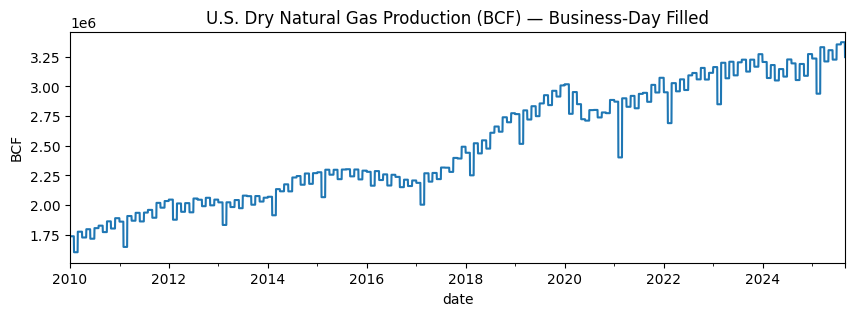

In [6]:
df_prod_biz.set_index("date")["production_bcf"].plot(figsize=(10,3))
plt.title("U.S. Dry Natural Gas Production (BCF) — Business-Day Filled")
plt.ylabel("BCF")
plt.show()